In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [2]:
import os
if not os.path.exists("./stan120"):
    os.mkdir("./stan120")

In [96]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")

Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

phi = 62/3
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [97]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X_obs = X.drop(index=rows_to_drop_Y)
Y_obs = Y.drop(index=rows_to_drop_Y)
X_miss = X.loc[rows_to_drop_Y,:]
Y_miss = Y.loc[rows_to_drop_Y,:]

#saving the indexes of the dataframes
X_obs_index = X_obs.index
Y_obs_index = Y_obs.index
X_miss_index = X_miss.index
Y_miss_index = Y_miss.index

# If you want to reset the index after dropping rows
X_obs = X_obs.reset_index(drop=True)
Y_obs = Y_obs.reset_index(drop=True)
X_miss = X_miss.reset_index(drop=True)
Y_miss = Y_miss.reset_index(drop=True)

In [100]:
stations_obs = X_obs.loc[:,'Station']
years_raw_obs = X_obs.loc[:,'Year']
months_raw_obs = X_obs.loc[:,'Month']
years_obs = X_obs.loc[:,'Year'] - 2009
unique_values_obs = sorted(set(stations_obs))
mapping_dict_obs = {value: index + 1 for index, value in enumerate(unique_values_obs)}
transformed_stations_obs = [mapping_dict_obs[value] for value in stations_obs]

transformed_stations_obs = pd.Series(transformed_stations_obs)
years_obs = pd.Series(years_obs)

stations_miss = X_miss.loc[:,'Station']
years_raw_miss = X_miss.loc[:,'Year']
months_raw_miss = X_miss.loc[:,'Month']
years_miss = X_miss.loc[:,'Year'] - 2009
unique_values_miss = sorted(set(stations_miss))
mapping_dict_miss = {value_miss: index_miss + 1 for index_miss, value_miss in enumerate(unique_values_miss)}
transformed_stations_miss = [mapping_dict_miss[value_miss] for value_miss in stations_miss]

transformed_stations_miss = pd.Series(transformed_stations_miss)
years_miss = pd.Series(years_miss)

day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month_obs = []
max_month_miss = []

for i in range(0,X_obs.shape[0]):
    max_month_obs.append(day_in_month[X_obs['Month'][i]-1])

for i in range(0,X_miss.shape[0]):
    max_month_miss.append(day_in_month[X_miss['Month'][i]-1])

max_month_obs = pd.Series(max_month_obs)
max_month_miss = pd.Series(max_month_miss)

In [101]:
X_obs = X_obs.drop(['Year','Station','Month'], axis  = 1)
X_miss = X_miss.drop(['Year','Station','Month'], axis  = 1)

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_obs_std = scaler.fit_transform(X_obs)
X_obs_std = pd.DataFrame(X_obs_std, columns=X_obs.columns)
X_obs_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_obs_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_obs_std.loc[:,"type_rural"] = pd.to_numeric(X_obs_std.loc[:,"type_rural"]).astype('Int64')
X_obs_std.loc[:,"type_urban"] = pd.to_numeric(X_obs_std.loc[:,"type_urban"]).astype('Int64')

X_miss_std = scaler.fit_transform(X_miss)
X_miss_std = pd.DataFrame(X_miss_std, columns=X_miss.columns)
X_miss_std.loc[:,"type_rural"] = X_miss.loc[:,"type_rural"]
X_miss_std.loc[:,"type_urban"] = X_miss.loc[:,"type_urban"]
X_miss_std.loc[:,"type_rural"] = pd.to_numeric(X_miss_std.loc[:,"type_rural"]).astype('Int64')
X_miss_std.loc[:,"type_urban"] = pd.to_numeric(X_miss_std.loc[:,"type_urban"]).astype('Int64')

In [7]:
stations = Y['idSensore']
years = Y['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = stations
stations = transformed_stations

In [8]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan120/base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

16:10:57 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan120\base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\base.exe
16:11:42 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\base.exe


In [9]:
data = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs_std
}


fit_base = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=200, iter_sampling=300)
posterior_base_az = az.from_cmdstanpy(fit_base)

16:11:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:11:58 - cmdstanpy - INFO - CmdStan done processing.


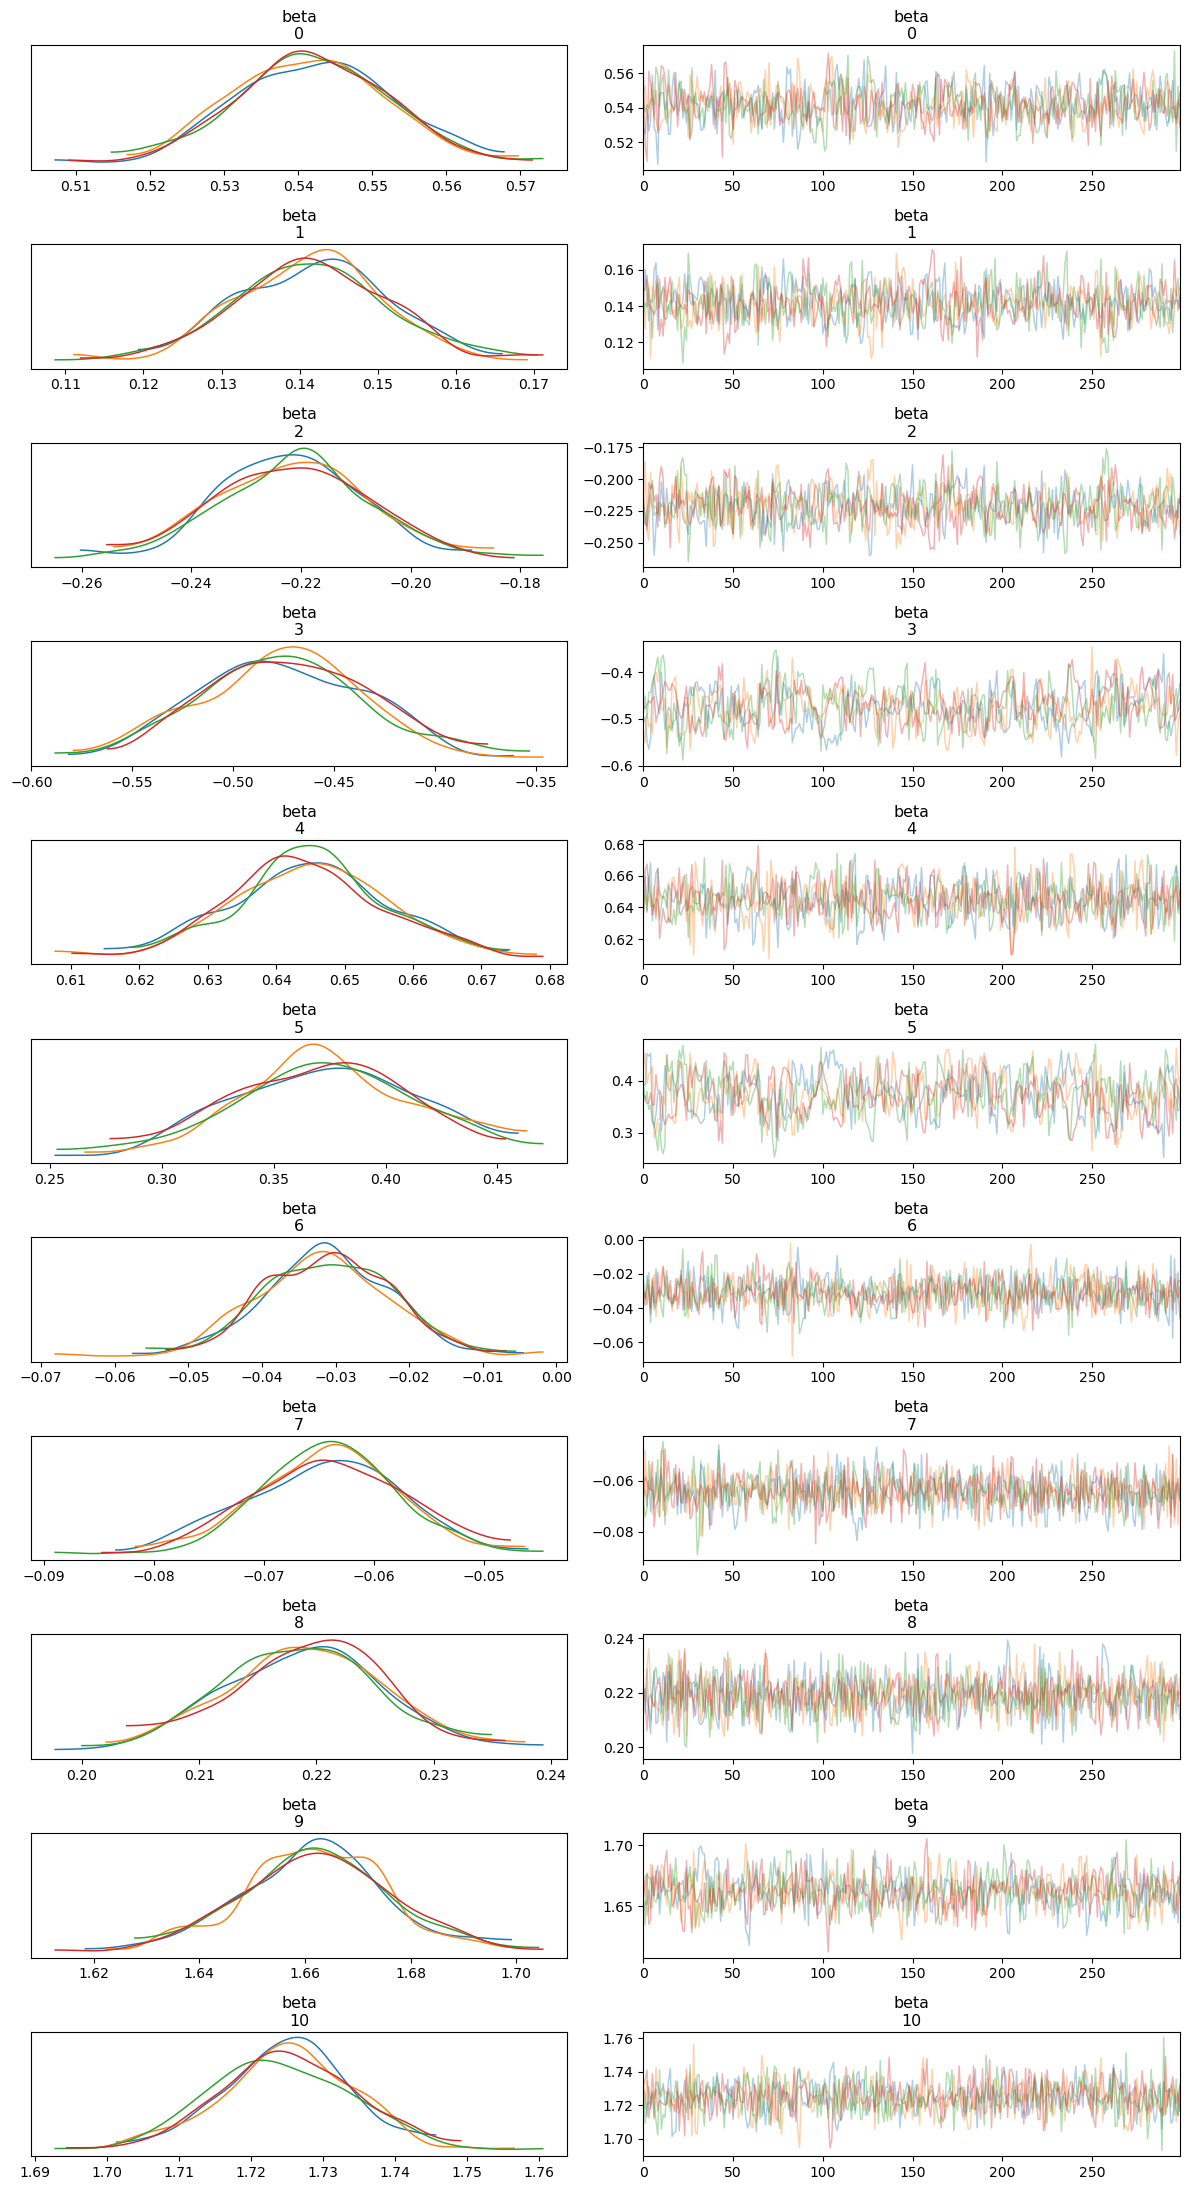

In [10]:
az.plot_trace(posterior_base_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [11]:
log_lik = fit_base.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


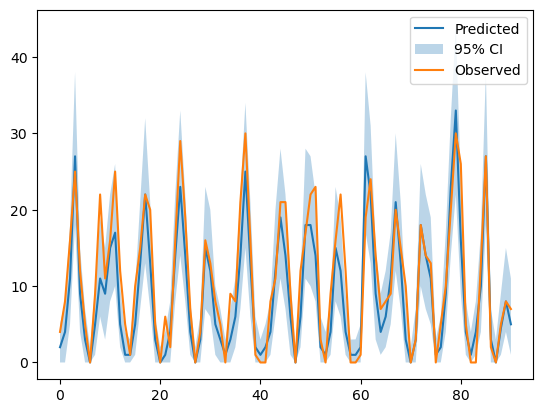

In [126]:
alpha = 0.05
y_pred_obs = posterior_base_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 91)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y_obs.loc[xx, 'Count_120'], label="Observed")
plt.legend()
plt.show()

In [13]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_base, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_base, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 1200 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13593.60   235.57
p_waic       41.97        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 1200 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13593.69   235.57
p_loo       42.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [140]:
in_ci = np.logical_and(Y_obs['Count_120'] >= y_star_low, Y_obs['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y_obs) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y_obs['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Inizializza un DataFrame vuoto
results_df = pd.DataFrame(columns=['Model', 'Percentage in CI', 'WAIC', 'LOO', 'MAD Median'])

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Base'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 91.25%
Mean Absolute Deviation (MAD) sulla mediana: 2.75712890625
          Model  Percentage in CI          WAIC           LOO  MAD Median
0  Modello Base             91.25 -10059.325101 -10060.132101    2.757129


C:\Users\leoma\AppData\Local\Temp\ipykernel_9620\2425798740.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_data], ignore_index=True)


Now we remove some variables, through two methods:\
    1. Variable selection through **SSVS**\
    2. Hard shrinkage in the posterior of the betas   
    
The code for the SSVS is on R in its folder, while the hard shrinkage will be in this file.

Given the SSVS paradigm, the covariates to remove are *max_consecutive_highwind_days*, *Densità*, *count_highwind*

In [15]:
##Code for hard shrinkage, hopefully same result
X.head

<bound method NDFrame.head of       mean_temperature  mean_precipitation_sum  mean_precipitation_hours  \
0            -1.415564               -0.613095                 -0.033854   
1            -0.664023                2.562416                  2.016839   
2             0.441882               -0.190293                  0.325219   
3             1.467529               -1.011831                 -0.989703   
4             0.543283                1.328997                  0.370040   
...                ...                     ...                       ...   
3835          1.357083               -0.743306                 -1.189132   
3836          1.994391               -1.624094                 -1.865982   
3837          1.461331               -0.779083                 -1.125677   
3838          0.232652               -0.345014                 -0.642717   
3839         -0.349283               -1.091885                 -1.488275   

      mean_windspeed_10m_max  mean_radiation_sum  count_h

Non togliere se runna con X_obs, nel caso in cui volessimo poi toglierle scriverlo

In [16]:
X_varSel = X_obs_std
X_varSel = X_varSel.drop(columns=['max_consecutive_highwind_days', 'Densità', 'type_rural', 'type_urban'])

In [17]:
var_sel_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}


"""

stan_file = "./stan120/var_sel_base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

var_sel_base = CmdStanModel(stan_file=stan_file)

16:12:14 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan120\var_sel_base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\var_sel_base.exe
16:12:41 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\var_sel_base.exe


In [18]:
data = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_varSel
}


fit_var_sel = var_sel_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_val_sel_az = az.from_cmdstanpy(fit_var_sel)

16:12:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:57 - cmdstanpy - INFO - CmdStan done processing.


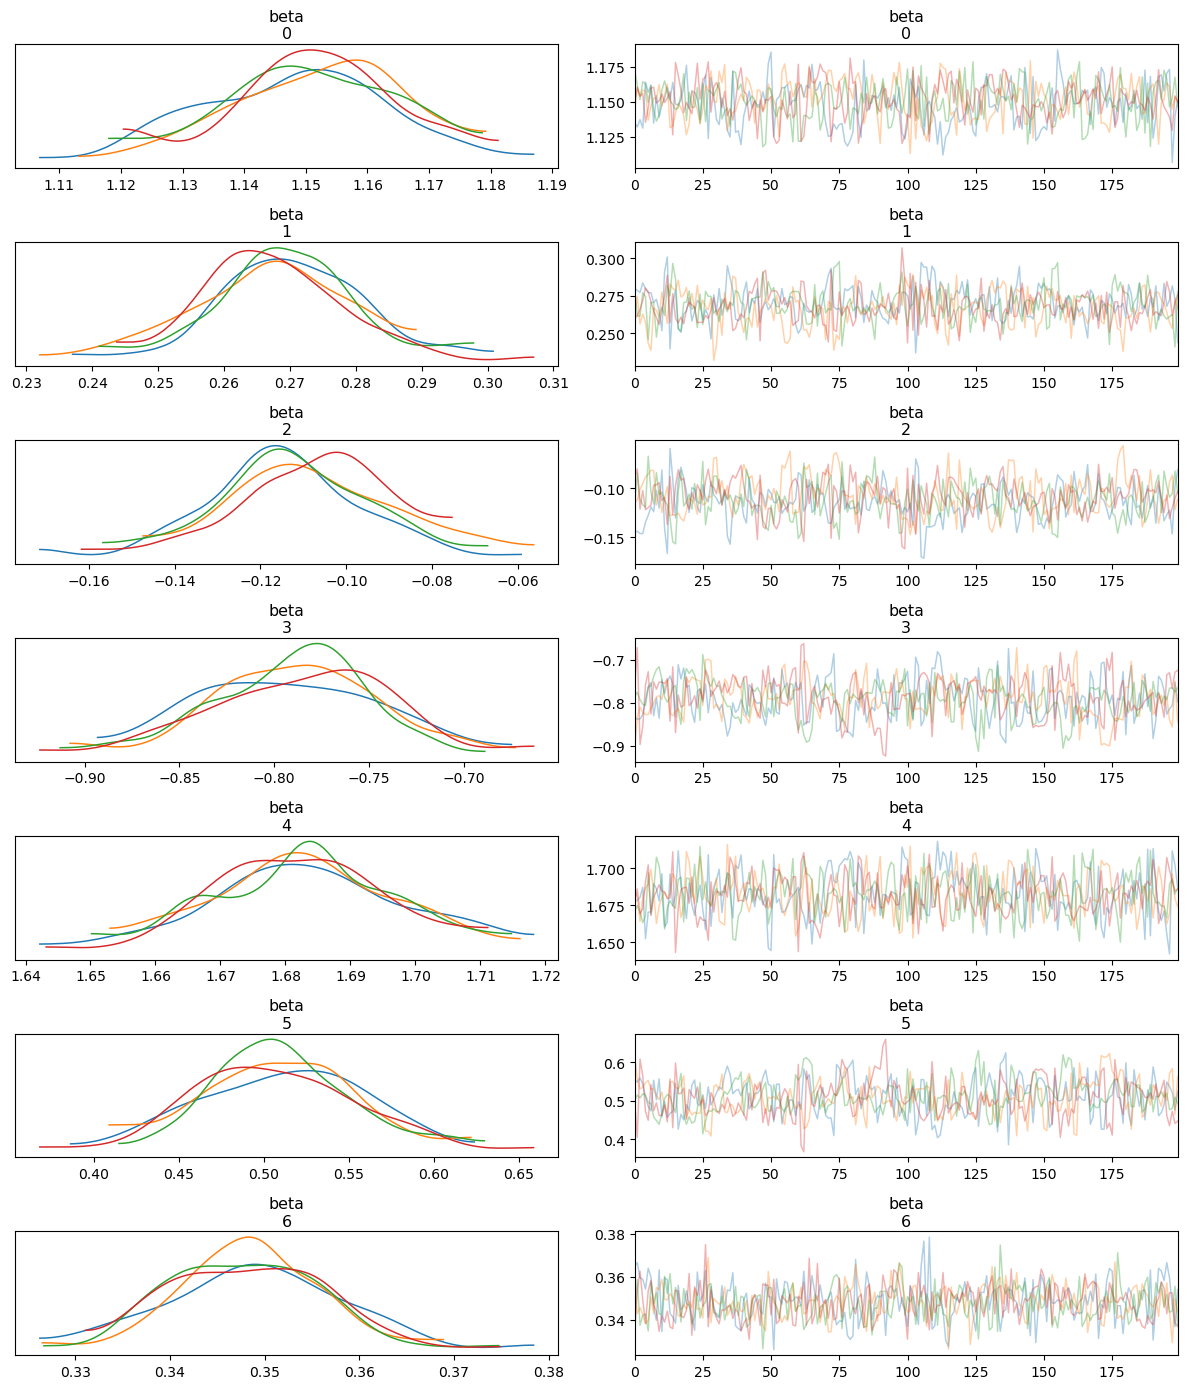

In [19]:
az.plot_trace(posterior_val_sel_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [20]:
log_lik = fit_var_sel.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


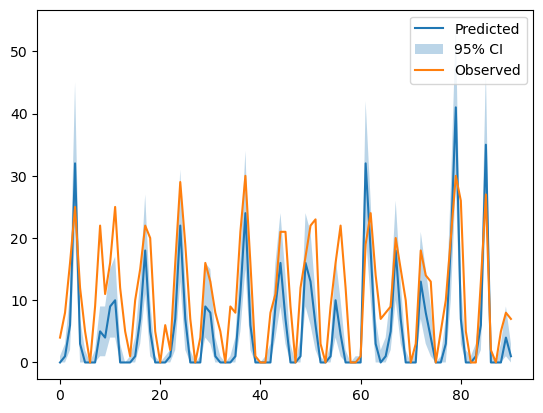

In [141]:
alpha = 0.05
y_pred_obs = posterior_val_sel_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 91)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y_obs.loc[xx, 'Count_120'], label="Observed")
plt.legend()
plt.show()

In [22]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_var_sel, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_var_sel, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -24873.44   476.90
p_waic       75.00        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -24873.68   476.90
p_loo       75.25        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3838   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [142]:
in_ci = np.logical_and(Y_obs['Count_120'] >= y_star_low, Y_obs['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y_obs) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y_obs['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Variable Selection'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 55.36%
Mean Absolute Deviation (MAD) sulla mediana: 2.75712890625
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         91.250000 -10059.325101 -10060.132101   
1  Modello Variable Selection         55.364583 -10059.325101 -10060.132101   

   MAD Median  
0    2.757129  
1    2.757129  


# Fit improvement
The threshold of 180 is very unlikely to be overcomed, with respect to the 120-threshold.\
This result in the presence of more zeros, and indeed *too much zeros*.\
The method for overcoming this issue is the **zero inflated Poisson** and the following is the code to implement this metodologies.

In [24]:
#Code for improve the fit

## Year model:
We add the factor accounting for different years.

In [25]:
year_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;

  array[N] int<lower=1> year;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}


"""

stan_file = "./stan120/years.stan"

with open(stan_file, "w") as f:
    print(year_model, file=f)

model_year = CmdStanModel(stan_file=stan_file)

16:13:08 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan120\years.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\years.exe
16:13:34 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\years.exe


In [26]:
    data = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs_std
}


fit_years = model_year.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_years_az = az.from_cmdstanpy(fit_years)

16:13:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:53 - cmdstanpy - INFO - CmdStan done processing.


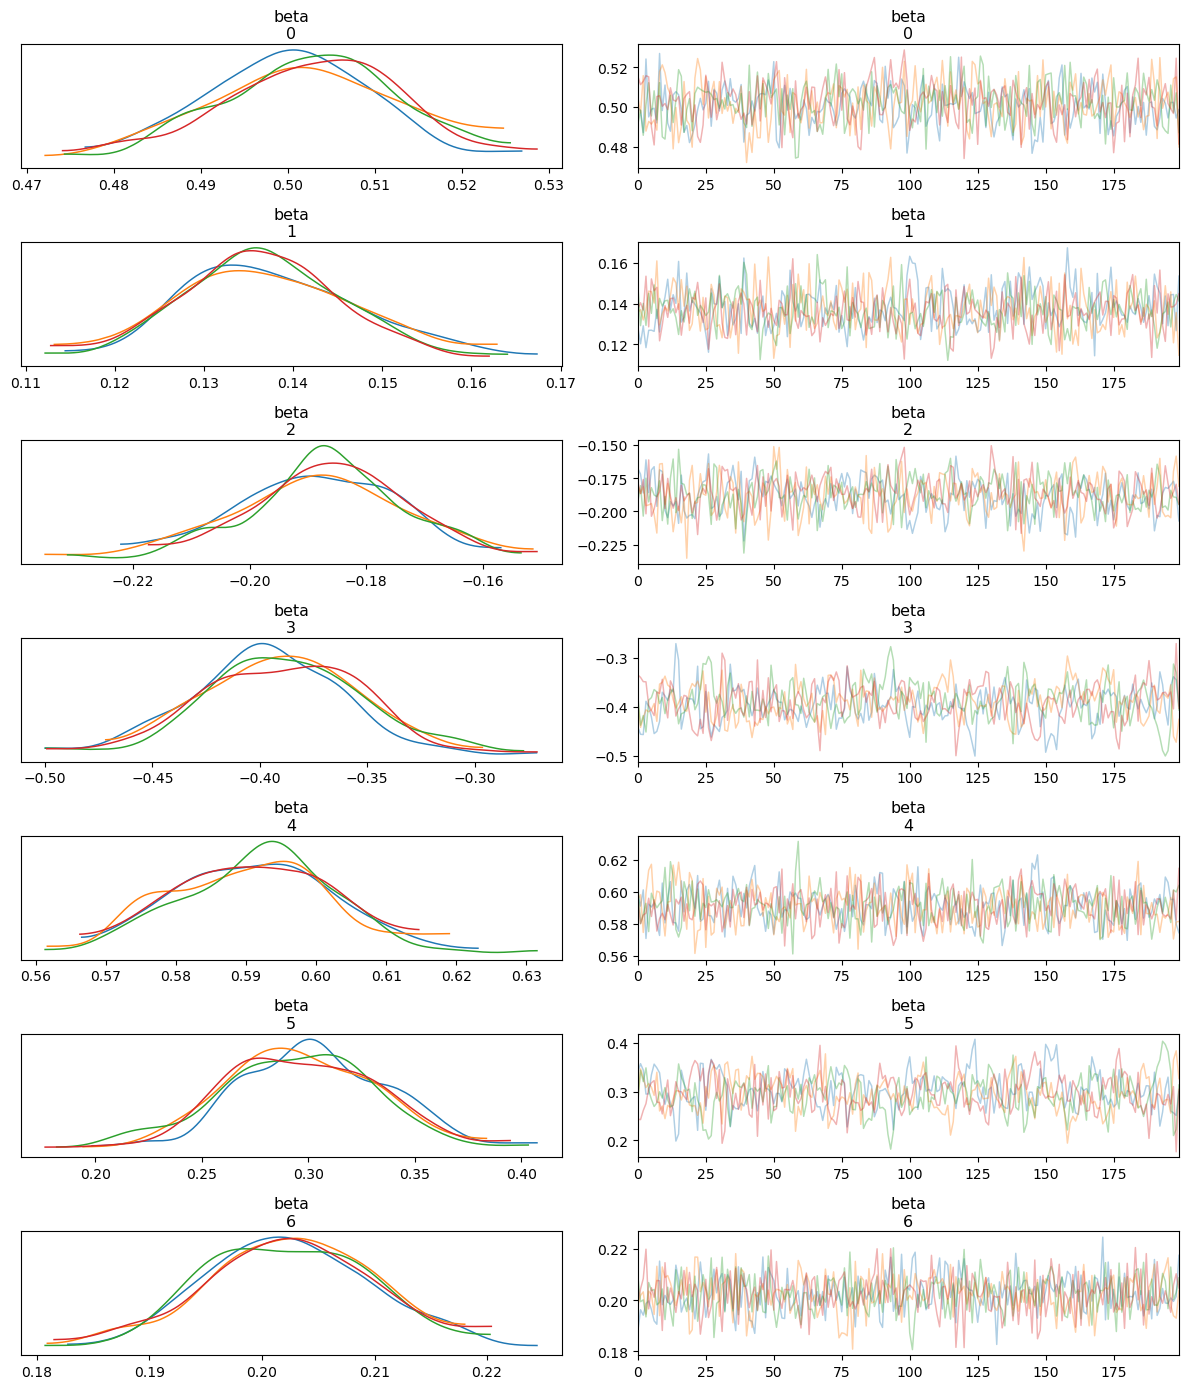

In [27]:
az.plot_trace(posterior_years_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [28]:
log_lik = fit_years.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


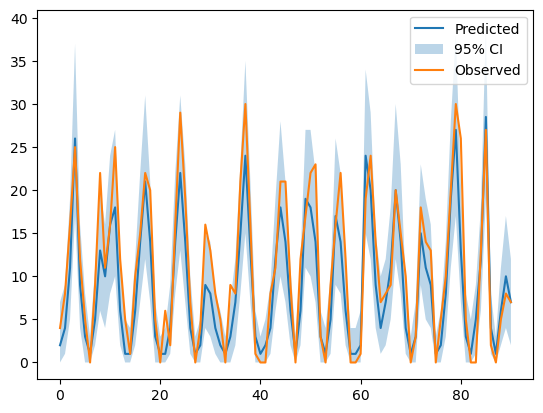

In [143]:
alpha = 0.05
y_pred_obs = posterior_years_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 91)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y_obs.loc[xx, 'Count_120'], label="Observed")
plt.legend()
plt.show()

In [144]:
# Crea un oggetto InferenceData contenente log_lik
#inference_years = az.from_cmdstanpy(fit_years, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_years, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_years, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11160.35   115.18
p_waic       51.50        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11160.59   115.18
p_loo       51.75        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [145]:
in_ci = np.logical_and(Y_obs['Count_120'] >= y_star_low, Y_obs['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y_obs) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y_obs['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Years'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 86.04%
Mean Absolute Deviation (MAD) sulla mediana: 2.75712890625
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         91.250000 -10059.325101 -10060.132101   
1  Modello Variable Selection         55.364583 -10059.325101 -10060.132101   
2               Modello Years         86.041667 -11160.345565 -11160.591465   

   MAD Median  
0    2.757129  
1    2.757129  
2    2.757129  


## Stations factor

After this upgrade, we account for the differences in the *stations* factor.

In [32]:
station_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan120/station.stan"

with open(stan_file, "w") as f:
    print(station_model, file=f)

model_station = CmdStanModel(stan_file=stan_file)

16:14:06 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan120\station.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\station.exe
16:14:33 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\station.exe


In [33]:
data = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs_std
}


fit_stations = model_station.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_station_az = az.from_cmdstanpy(fit_stations)

16:14:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:15:41 - cmdstanpy - INFO - CmdStan done processing.


16:15:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 iterations at max treedepth (1.0%)
	Chain 2 had 22 iterations at max treedepth (11.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


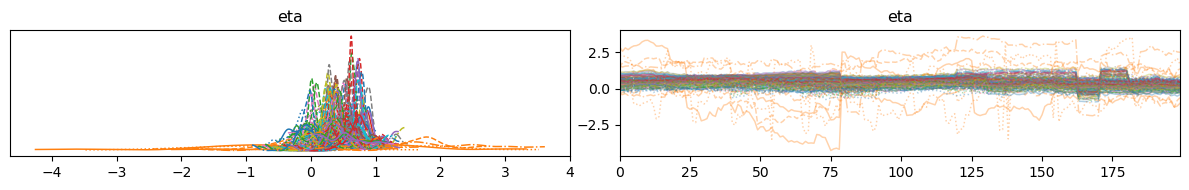

In [34]:
az.plot_trace(posterior_station_az, var_names = ['eta'], compact=True)
plt.tight_layout()
plt.show()

In [35]:
eta = posterior_station_az['posterior']['eta']
eta
len(np.unique(stations))

45

In [47]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [48]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations_original)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [49]:
csv_path = '../Datasets/Space_estimate/eta_120.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)

In [50]:
lam = posterior_station_az['posterior']['lambda']
inference_lam = []
for i in range(len(Y['Count_120'])):
    ar1 = lam[0, :, i]-Y_obs['Count_120'][i]
    ar2 = lam[1, :, i]-Y_obs['Count_120'][i]
    ar3 = lam[2, :, i]-Y_obs['Count_120'][i]
    ar4 = lam[3, :, i]-Y_obs['Count_120'][i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference_lam.append(current_iteration_df)
    
df = pd.DataFrame(inference_lam).transpose()
df.shape
df.columns.values
csv_path = '../Datasets/Space_estimate/res_120.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)

In [51]:
df.shape

(800, 3840)

In [40]:
log_lik = fit_stations.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


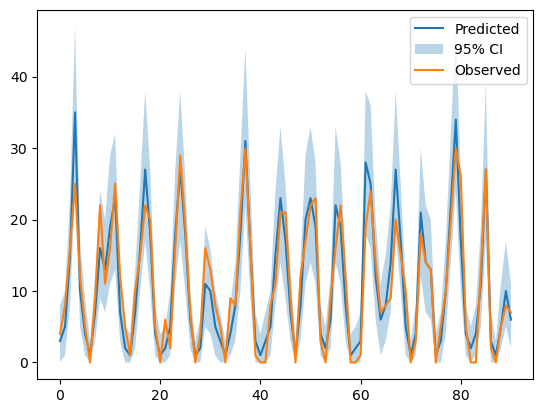

In [146]:
alpha = 0.05
y_pred_obs = posterior_station_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 91)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y_obs.loc[xx, 'Count_120'], label="Observed")
plt.legend()
plt.show()

In [42]:
sum(y_star_up>30)

210

In [148]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_stations, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_stations, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10101.78    86.30
p_waic      101.78        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10102.36    86.31
p_loo      102.35        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [149]:
in_ci = np.logical_and(Y_obs['Count_120'] >= y_star_low, Y_obs['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y_obs) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y_obs['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Stations'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 91.12%
Mean Absolute Deviation (MAD) sulla mediana: 2.75712890625
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         91.250000 -10059.325101 -10060.132101   
1  Modello Variable Selection         55.364583 -10059.325101 -10060.132101   
2               Modello Years         86.041667 -11160.345565 -11160.591465   
3            Modello Stations         91.119792 -10101.779528 -10102.355464   

   MAD Median  
0    2.757129  
1    2.757129  
2    2.757129  
3    2.757129  


## Proper space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [72]:
space_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
    matrix[nstations,nstations] H = exp(-(1/(phi^2)) * (distances.^2));

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
  real<lower = 0> sigma;
  real<lower = 0> sigma_beta;
  real<lower = 0> sigma_xi;
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;
    matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, sigma_beta);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, sigma_xi);
  eta ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma_beta ~ inv_gamma(4, 2);
  sigma_xi ~ inv_gamma(4, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan120/space.stan"

with open(stan_file, "w") as f:
    print(space_model, file=f)

model_space = CmdStanModel(stan_file=stan_file)

16:37:01 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan120\space.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\space.exe
16:37:43 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\space.exe


In [73]:
phi = 62/3
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [74]:
data = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs_std,
    "phi": phi,
    "distances": distances
}


fit_space = model_space.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_space_az = az.from_cmdstanpy(fit_space)

16:37:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:38:45 - cmdstanpy - INFO - CmdStan done processing.
16:38:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 37, column 4 to column 65)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'space.stan', line 37, column 4 to column 65)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'space.stan', line 37, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 37, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 37, column 4 to column 65)
Consider re-running with show_console=True if the above output is unclear!


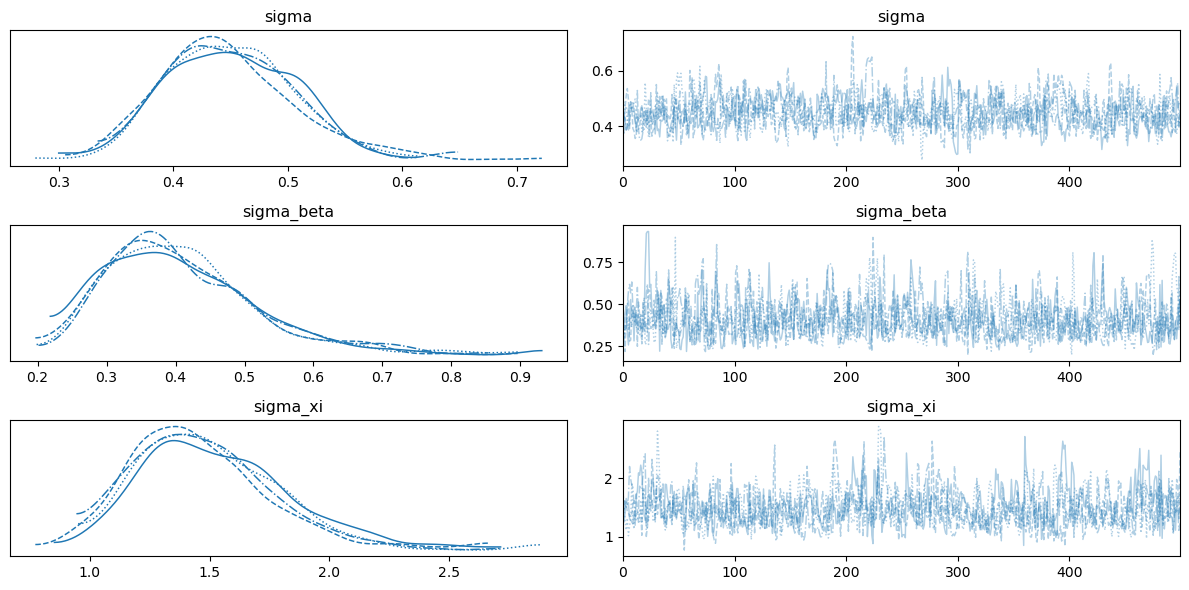

In [75]:
az.plot_trace(posterior_space_az, var_names = ['sigma', 'sigma_beta', 'sigma_xi'], compact=True)
plt.tight_layout()
plt.show()

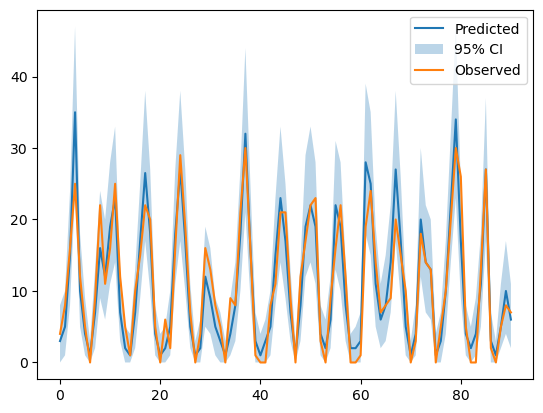

In [150]:
alpha = 0.05
y_pred_obs = posterior_space_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 91)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y_obs.loc[xx, 'Count_120'], label="Observed")
plt.legend()
plt.show()

In [77]:
sum(y_star_up>30)

208

In [152]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_space, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_space, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10101.78    86.04
p_waic       99.75        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10102.12    86.05
p_loo      100.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [153]:
in_ci = np.logical_and(Y_obs['Count_120'] >= y_star_low, Y_obs['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y_obs) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y_obs['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Space1'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 91.30%
Mean Absolute Deviation (MAD) sulla mediana: 2.75712890625
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         91.250000 -10059.325101 -10060.132101   
1  Modello Variable Selection         55.364583 -10059.325101 -10060.132101   
2               Modello Years         86.041667 -11160.345565 -11160.591465   
3            Modello Stations         91.119792 -10101.779528 -10102.355464   
4              Modello Space1         91.302083 -10101.784305 -10102.118141   

   MAD Median  
0    2.757129  
1    2.757129  
2    2.757129  
3    2.757129  
4    2.757129  


### Other type of space model
Here the random efffect related to the space is not integrated out

In [81]:
space_model_bis = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
    matrix[nstations,nstations] H = exp(-(1/(phi^2)) * (distances.^2));

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
  vector[nstations] w; //Random zero-mean effect for the space model
  real<lower = 0> sigma;
  real<lower = 0> sigma_eta;
  real<lower = 0> sigma_beta;
  real<lower = 0> sigma_xi;
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;
    matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


    fix_eff = X * beta;
    intercept = xi[year] + eta[stations] + w[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, sigma_beta);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, sigma_xi);
  eta ~ normal(0, sigma_eta);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma_eta ~ inv_gamma(2, 2);
  sigma_beta ~ inv_gamma(4, 2);
  sigma_xi ~ inv_gamma(4, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan120/space_bis.stan"

with open(stan_file, "w") as f:
    print(space_model_bis, file=f)

model_space_bis = CmdStanModel(stan_file=stan_file)

16:39:30 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan120\space_bis.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\space_bis.exe
16:40:13 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\space_bis.exe


In [82]:
data = {
    "N": len(Y_obs),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_120'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}


fit_space_bis = model_space_bis.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_space_bis_az = az.from_cmdstanpy(fit_space_bis)

16:40:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:47:16 - cmdstanpy - INFO - CmdStan done processing.
16:47:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'space_bis.stan', line 39, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 39, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 39, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 39, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 39, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 39, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1]

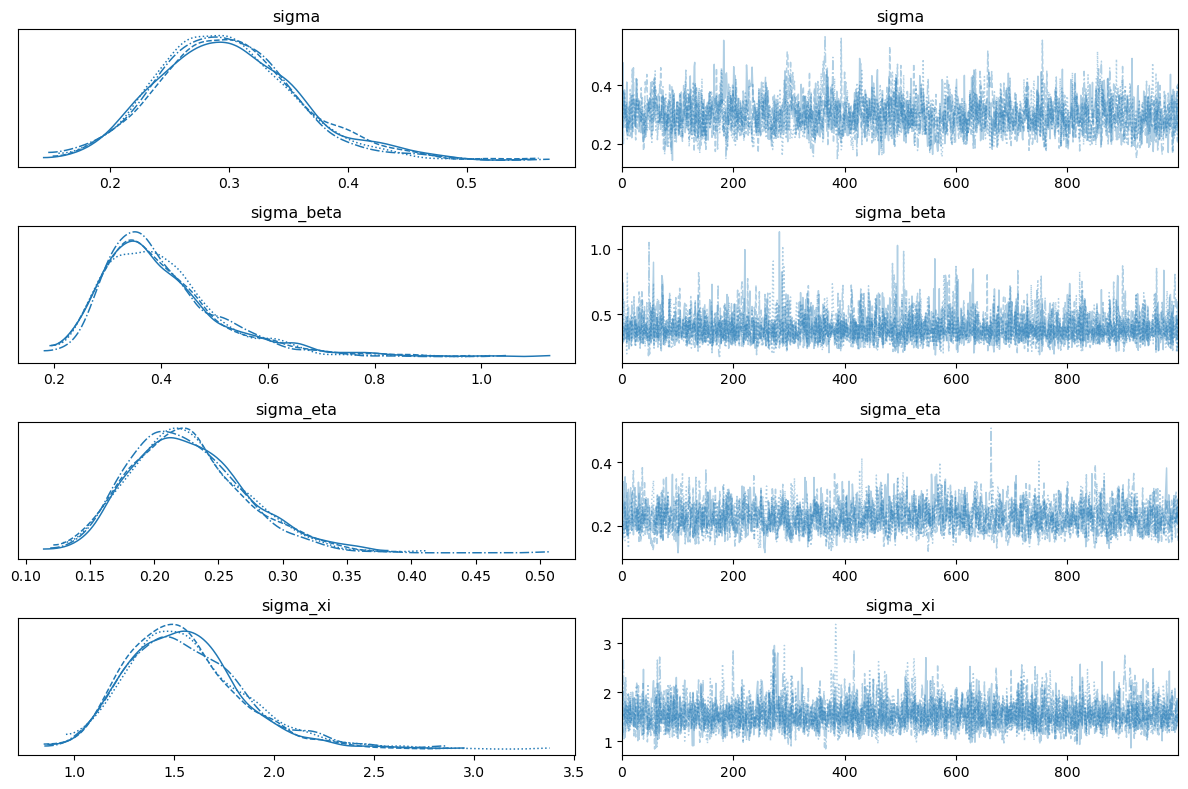

In [83]:
az.plot_trace(posterior_space_bis_az, var_names = ['sigma', 'sigma_beta', 'sigma_eta', 'sigma_xi'], compact=True)
plt.tight_layout()
plt.show()

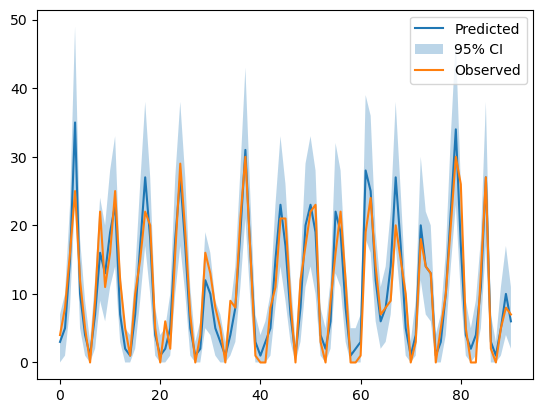

In [154]:
alpha = 0.05
y_pred_obs = posterior_space_bis_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 91)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y_obs.loc[xx, 'Count_120'], label="Observed")
plt.legend()
plt.show()

In [155]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers.shape)

(336,)


In [86]:
sum(y_star_up>30)

209

In [156]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_space_bis, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_space_bis, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 4000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10101.04    86.03
p_waic      100.77        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 4000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10101.24    86.04
p_loo      100.97        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [157]:
in_ci = np.logical_and(Y_obs['Count_120'] >= y_star_low, Y_obs['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y_obs) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y_obs['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Space2'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 91.25%
Mean Absolute Deviation (MAD) sulla mediana: 2.75712890625
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         91.250000 -10059.325101 -10060.132101   
1  Modello Variable Selection         55.364583 -10059.325101 -10060.132101   
2               Modello Years         86.041667 -11160.345565 -11160.591465   
3            Modello Stations         91.119792 -10101.779528 -10102.355464   
4              Modello Space1         91.302083 -10101.784305 -10102.118141   
5              Modello Space2         91.250000 -10101.036904 -10101.240515   

   MAD Median  
0    2.757129  
1    2.757129  
2    2.757129  
3    2.757129  
4    2.757129  
5    2.757129  


## Per Coppe
Modello con sia la dummy per Luglio che lo space model aggiornato.

In [103]:
years_to_repeat = [2010, 2015, 2022]
station_to_repeat = [9991]
months_to_repeat = [7]

dummy_july = np.zeros(X.shape[0])
dummy_temp = np.zeros(X.shape[0])
dummy_prec_sum = np.zeros(X.shape[0])
dummy_prec_hours = np.zeros(X.shape[0])
dummy_rad = np.zeros(X.shape[0])
dummy_cov_inter = np.zeros(X.shape[0])
dummy_tot_inter = np.zeros(X.shape[0])

T_threshold = np.percentile(X['mean_temperature'], 95)
P_sum_threshold = np.percentile(X['mean_precipitation_sum'], 5)
P_hours_threshold = np.percentile(X['mean_precipitation_hours'], 5)
Rad_threshold = np.percentile(X['mean_radiation_sum'], 95)

idx_july = np.where(X['Month'].isin(months_to_repeat))[0]
idx_temp = np.where(X['mean_temperature'] >= T_threshold)[0]
idx_p_sum = np.where(X['mean_precipitation_sum'] <= P_sum_threshold)[0]
idx_p_hours = np.where(X['mean_precipitation_hours'] <= P_hours_threshold)[0]
idx_rad = np.where(X['mean_radiation_sum'] >= Rad_threshold)[0]
idx_cov_inter = np.unique(np.concatenate((idx_temp, idx_p_sum, idx_p_hours, idx_rad)))
idx_tot_inter = np.unique(np.concatenate((idx_july, idx_cov_inter)))

dummy_july[idx_july] = 1
dummy_temp[idx_temp] = 1
dummy_prec_sum[idx_p_sum] = 1
dummy_prec_hours[idx_p_hours] = 1
dummy_rad[idx_rad] = 1
dummy_cov_inter[idx_cov_inter] = 1
dummy_tot_inter[idx_tot_inter] = 1

dummy_july_obs = pd.Series(dummy_july[X_obs_index])
dummy_temp_obs = pd.Series(dummy_temp[X_obs_index])
dummy_prec_sum_obs = pd.Series(dummy_prec_sum[X_obs_index])
dummy_prec_hours_obs = pd.Series(dummy_prec_hours[X_obs_index])
dummy_rad_obs = pd.Series(dummy_rad[X_obs_index])
dummy_cov_inter_obs = pd.Series(dummy_cov_inter[X_obs_index])
dummy_tot_inter_obs = pd.Series(dummy_tot_inter[X_obs_index])

dummy_july_miss = pd.Series(dummy_july[X_miss_index])
dummy_temp_miss = pd.Series(dummy_temp[X_miss_index])
dummy_prec_sum_miss = pd.Series(dummy_prec_sum[X_miss_index])
dummy_prec_hours_miss = pd.Series(dummy_prec_hours[X_miss_index])
dummy_rad_miss = pd.Series(dummy_rad[X_miss_index])
dummy_cov_inter_miss = pd.Series(dummy_cov_inter[X_miss_index])
dummy_tot_inter_miss = pd.Series(dummy_tot_inter[X_miss_index])

In [107]:
code_120_dummy = """
data {
  int<lower=0> N; // Number of observations
  int<lower=0> N_miss; // Number of missing observations
  int<lower=0> P; // Covariate number
  int<lower=0> nyears;
  int<lower=0> nstations;

  array[N] int<lower=0> station;
  array[N] int<lower=0> year;
  array[N] int<lower=0> max_month;

  array[N_miss] int<lower=0> station_miss;
  array[N_miss] int<lower=0> year_miss;
  array[N_miss] int<lower=0> max_month_miss;
  
  array[N] int<lower=0> y; // Count data

  matrix[N, P] X; // Predictor matrix
  matrix[N_miss, P] X_miss; // Predictor matrix

  real phi;
  matrix[nstations, nstations] distances;

  vector[N] dummy_obs;
  vector[N_miss] dummy_miss;

  int<lower=0,upper=3> sampling_type;
}

transformed data {
  matrix[nstations,nstations] H = exp(-(1/(phi^2)) * (distances.^2));
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years
  vector[nstations] w; //Random zero-mean effect for the space model
  real<lower = 0> sigma;
  real<lower = 0> sigma_beta;
  real<lower = 0> sigma_xi;
  real<lower = 0> sigma_eta;
  vector[nstations] dummy_beta;
}

transformed parameters {
  vector[N] lambda;
  vector[N] fix_eff;
  vector[N] dummy_eff;
  vector[N] intercept;

  vector[N_miss] lambda_miss;
  vector[N_miss] fix_eff_miss;
  vector[N_miss] dummy_eff_miss;
  vector[N_miss] intercept_miss;

  matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
  matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


  fix_eff = X * beta;
  for (i in 1:N) {
    dummy_eff[i] = dummy_obs[i] * dummy_beta[station[i]];
  }
  intercept = xi[year] + eta[station] + w[station] + dummy_eff;
  lambda = exp(fix_eff + intercept);

  fix_eff_miss = X_miss * beta;
  for (i in 1:N_miss) {
    dummy_eff_miss[i] = dummy_miss[i] * dummy_beta[station_miss[i]];
  }
  intercept_miss = xi[year_miss] + eta[station_miss] + w[station_miss] + dummy_eff_miss;
  lambda_miss = exp(fix_eff_miss + intercept_miss);

  /*
  for (i in 1:N) {
    if (lambda[i] > max_month[i]) {
      lambda[i] = max_month[i];
    }
  }

  for (i in 1:N_miss) {
    if (lambda_miss[i] > max_month_miss[i]) {
      lambda_miss[i] = max_month_miss[i];
    }
  }
  */
}

model {
  beta ~ normal(0, sigma_beta);
  for (i in 1:N) {
    y[i] ~ poisson(lambda[i]);
  };

  xi ~ normal(0, sigma_xi);
  eta ~ normal(0, sigma_eta);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma_eta ~ inv_gamma(2, 2);
  sigma_beta ~ inv_gamma(4, 2);
  sigma_xi ~ inv_gamma(4, 2);
  dummy_beta ~ normal(-1, 2);
}

generated quantities {
  vector[N] log_lik;
  vector[N] y_pred;
  vector[N_miss] y_pred_miss;

  for(i in 1:N) {
    log_lik [ i ] = poisson_lpmf (y[i] | lambda[i]);
  }

  if (sampling_type == 0) {
    for (i in 1:N) {
     y_pred[i] = poisson_rng(lambda[i]);
    }

    for (i in 1:N_miss) {
      y_pred_miss[i] = poisson_rng(lambda_miss[i]);
    }
  }
  
  if (sampling_type == 1) {
    for(i in 1:N){
    real y_temp = max_month[i] + 1;
      while (y_temp > max_month[i]) {
        y_temp = poisson_rng(lambda[i]);
      };
      y_pred[i] = y_temp;
    }

    for(i in 1:N_miss){
      real y_temp = max_month_miss[i] + 1;
      while (y_temp > max_month_miss[i]){
        y_temp = poisson_rng(lambda_miss[i]);
      };
      y_pred_miss[i] = y_temp;
    }
  }  

  if (sampling_type == 2) {
    for (i in 1:N) {
      if (y_pred[i] > max_month[i]) {
        y_pred[i] = max_month[i];
      }
    }

    for (i in 1:N_miss) {
      if (y_pred_miss[i] > max_month_miss[i]) {
        y_pred_miss[i] = max_month_miss[i];
      }
    }
  }
  
  if (sampling_type == 3) {
    for (i in 1:N) {
      real sum_p = 0;
      real u = uniform_rng(0, 1);
      for (b in 0:max_month[i]) {
        sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
        if (sum_p >= u) {
          y_pred[i] = b;
          break;
        }
      }
    }

    for (i in 1:N_miss) {
      real sum_p = 0;
      real u = uniform_rng(0, 1);
      for (b in 0:max_month[i]) {
        sum_p = sum_p + exp(poisson_lpmf(b | lambda_miss[i]) - poisson_lcdf(max_month[i] | lambda_miss[i]));
        if (sum_p >= u) {
          y_pred_miss[i] = b;
          break;
        }
      }
    }
  }
  
}
"""
stan_file = "./stan120/120_dummy.stan"

with open(stan_file, "w") as f:
    print(code_120_dummy, file=f)

model_120_dummy = CmdStanModel(stan_file=stan_file)

17:03:48 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan120\120_dummy.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\120_dummy.exe
17:04:29 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan120\120_dummy.exe


In [108]:
data_120_july = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs,
    "dummy_miss": dummy_july_miss,
    "sampling_type": 0  # 0 for poisson, 1 for rejection, 2 for hard cap, 3 for truncated poisson
}

fit_120_july = model_120_dummy.sample(data=data_120_july, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_july = az.from_cmdstanpy(fit_120_july)

17:04:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:09:17 - cmdstanpy - INFO - CmdStan done processing.
17:09:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in '120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in '120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in '120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in '120_dummy.stan', line 59, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in '120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in '120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] 

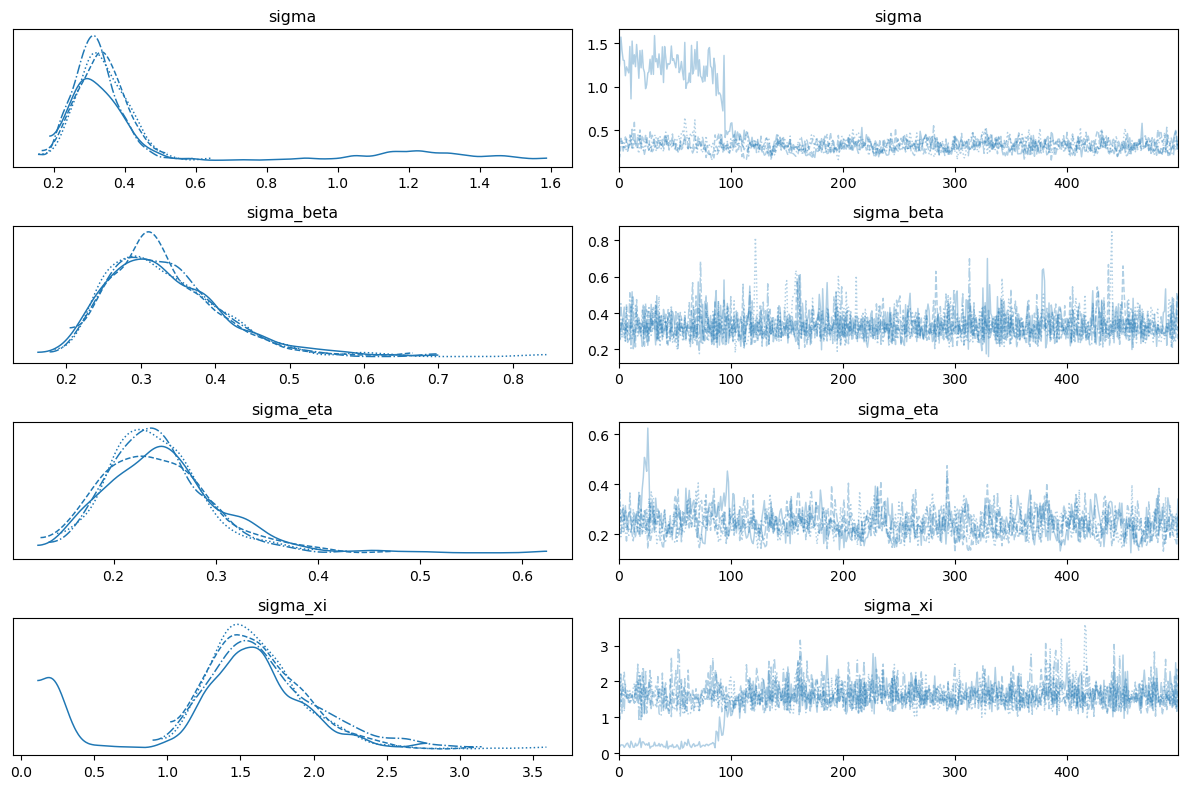

In [109]:
az.plot_trace(posterior_120_july, var_names = ['sigma', 'sigma_beta', 'sigma_eta', 'sigma_xi'], compact=True)
plt.tight_layout()
plt.show()

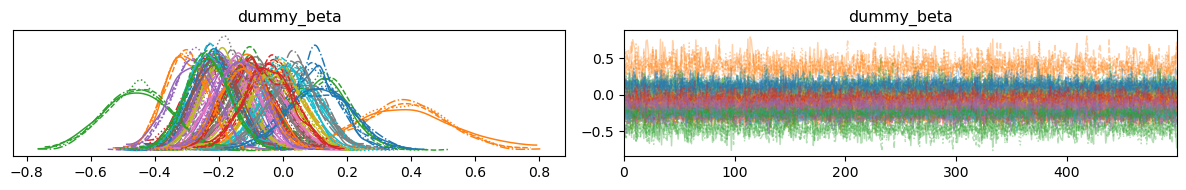

In [112]:
az.plot_trace(posterior_120_july, var_names = ['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

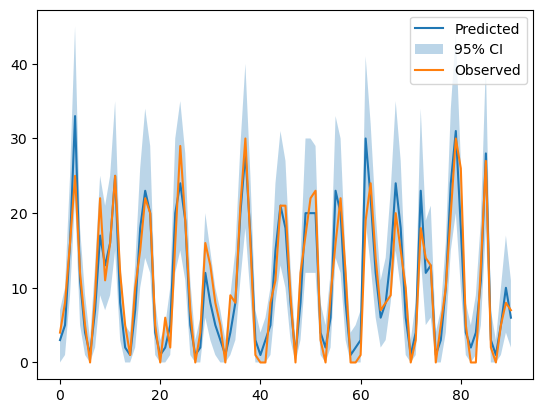

In [158]:
alpha = 0.05
y_pred_obs = posterior_120_july.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 91)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y_obs.loc[xx, 'Count_120'], label="Observed")
plt.legend()
plt.show()

In [159]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers.shape)

(334,)


In [171]:
(np.where(y_star>31))

(array([   3,  591,  674,  867, 1086, 1387, 2139, 2387, 2648, 2655, 2699,
        2713, 2734, 2735, 2906, 3035, 3122, 3423, 3545, 3757, 3788],
       dtype=int64),)

In [160]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(posterior_120_july, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(posterior_120_july, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10059.33    86.56
p_waic      160.43        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10060.13    86.57
p_loo      161.23        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [161]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)

in_ci = np.logical_and(Y_obs['Count_120'] >= y_star_low, Y_obs['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y_obs) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y_obs['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Space2 con dummy luglio'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 91.30%
Mean Absolute Deviation (MAD) sulla mediana: 2.75712890625
                             Model  Percentage in CI          WAIC  \
0                     Modello Base         91.250000 -10059.325101   
1       Modello Variable Selection         55.364583 -10059.325101   
2                    Modello Years         86.041667 -11160.345565   
3                 Modello Stations         91.119792 -10101.779528   
4                   Modello Space1         91.302083 -10101.784305   
5                   Modello Space2         91.250000 -10101.036904   
6  Modello Space2 con dummy luglio         91.302083 -10059.325101   

            LOO  MAD Median  
0 -10060.132101    2.757129  
1 -10060.132101    2.757129  
2 -11160.591465    2.757129  
3 -10102.355464    2.757129  
4 -10102.118141    2.757129  
5 -10101.240515    2.757129  
6 -10060.132101    2.757129  
